#### Notebook config

In [20]:
# %load ../../software/fullwavepy/fullwavepy/config/jupyter.py 
from arrau import *
from fullwavepy import * # Load modules imported in fullwavepy/__init__.py
# -----------------------------------------------------------------------------
# Set aliases of frequently used jupyter magic commands
# -----------------------------------------------------------------------------
%alias_magic mi matplotlib -p inline
%alias_magic mn matplotlib -p notebook
# -----------------------------------------------------------------------------
# Set matplotlib backend
# -----------------------------------------------------------------------------
# non-interactive plots displayed in a notebook cell
%matplotlib inline
# interactive plots displayed in a notebook cell
# %matplotlib notebook (interactive version)
# -----------------------------------------------------------------------------
# Set matplotlib style
# ----------------------------------------------------------------------------
plt.style.reload_library()
# a combined style (right overwrites left wherever they overlap):
plt.style.use(['default', 'ggplot', 'kmc_test'])
# print(plt.style.available) 
# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
# Set up loggers, handlers and load the log_lvl function
from fullwavepy.config.logging import *
# -----------------------------------------------------------------------------
# Set level of log-messages
log_lvl(ERROR) 
# Other options in order of increasing importance and 
# decreasing verbosity:
# TRACE, DEBUG, INFO, WARNING, ERROR, CRITICAL
# or using integers: 0, 10, 20, 30, 40, 50, respectively
# -----------------------------------------------------------------------------
# Autocompleting
# -----------------------------------------------------------------------------
#  Not sure if it works
%config IPCompleter.greedy=True 
# -----------------------------------------------------------------------------
# Automatically reload modules before execution
#%load_ext autoreload
#%autoreload 2

Created `%mi` as an alias for `%matplotlib inline`.
Created `%mn` as an alias for `%matplotlib notebook`.


In [46]:
xp = PROTEUS()
path_eph = '/home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano'
exe = { 
    'fullwave':  '~/PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'fullwave_local': '/home/kmc3817/light_PhD/fullwave3D/rev690/bin/fullwave3D.exe',
    'segyprep':  '/home/kmc3817/light_PhD/fullwave3D/segyprep_v3.16/bin/segyprep_v3.16'} 
b01 = xp.box['kol1'].box

##### Init synthetic project (see `0831...ipynb`)

In [33]:
dis01 = {
 'dt': 0.0025,
 'dx': 50,
 'ns': 3000} # NOTE

In [34]:
info = "Calculate synthetics through p14.out.vp.it[80]"
s01 = ProjSyn('method_s01', path = './', exe=exe, info=info, box=b01, **dis01, cat=0)

# Inversion project

In [19]:
# init project 
# path = path_eph
# path = './'
# # env = {'SLAVES_WAVEFIELDSVTR': -100} # take a wavefield snapshot every 100 time steps
# kwargs = dict(path=path, exe=exe, box=box, dt=dt, ns=s01.ns, dx=s01.dx, cat=0)
# i01 = ProjInv('method_i01', **kwargs)

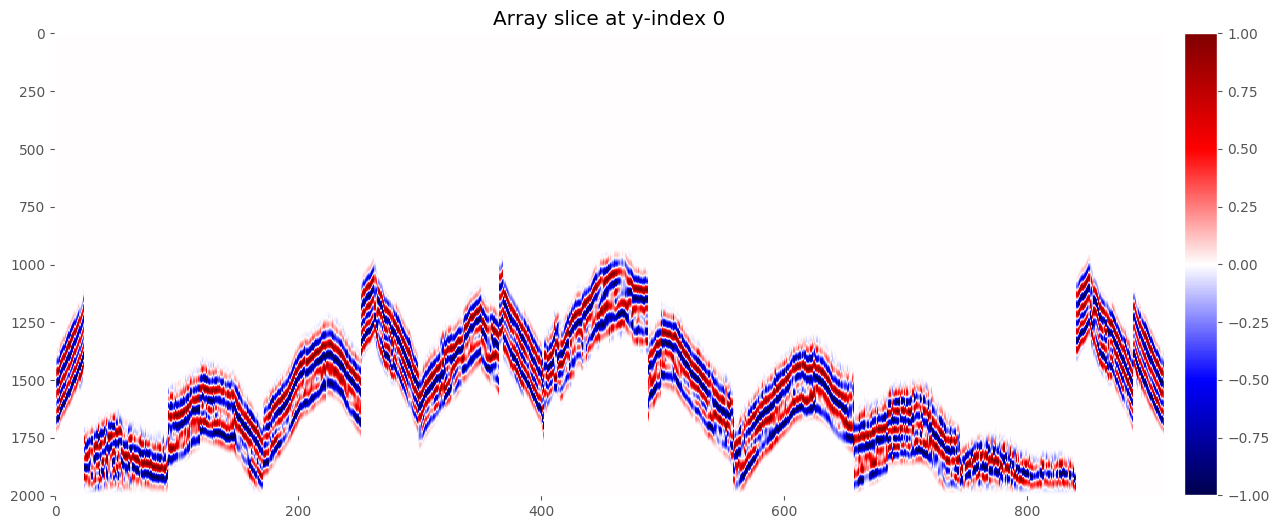

In [67]:
figure(15)
p14.i.obs.plot(win=dict(tracf=[4104]), norm='max')

## Inp

Prepare input:

In [74]:
i01.i.obs.raw.fname

'.//method_i01//inp/method_i01-Observed_raw.sgy'

In [75]:
%%time 
i01.i.svp.dupl(s01.i.tvp.fname)
i01.i.rsg.dupl(s01.i.rsg.fname)
# i01.i.obs.dupl(s01.i.ose.fname) NOTE this is instead prepared by the pre-processor
i01.i.obs.raw.dupl(s01.i.ose.fname)
i01.i.rse.prep(fnames=[i01.i.obs.raw.name])
i01.i.sp.prep(reciprocity=True, ztype='d')

Content of  .//method_i01//inp/method_i01-RawSeis.txt : 
method_i01-Observed_raw.sgy
 
Content of  .//method_i01//inp/method_i01-SegyPrep.key : 
FFID : yes
addtodepth : 0
debug : yes
dtms : 2.5
dx : 50.0
fixedarray : yes
geometry : segy
io : sgy
maxoffset : 1000000.0
minoffset : 0
nx1 : 341
nx2 : 361
nx3 : 81
outseis : yes
outsource : yes
problem : tomography
reciprocity : True
retain : yes
text : yes
ttime : 7.5
unique : yes
xorigin : 8000.0
xshift : 0
yorigin : -3000.0
yshift : 0
ztype : d
 
CPU times: user 16 ms, sys: 28 ms, total: 44 ms
Wall time: 1.84 s


Pre-process the input. In particular `obs.raw` file is pre-processed and output as `obs` file. This matters only if the discretisation differs from the one in the synthetic project.

In [20]:
%%time 
i01.i.sp.run()
i01.i.rnf.prep(b_abs=40, e_abs=50)

NameError: name 'i01' is not defined

Process the observed data (`obs` file). This is quite slow (2.5 min), thus it may be a better idea to keep the processed data ready to be re-used.

In [78]:
%%time 
kw_filt = {'pad': 100, 'f1': 2, 'f2': 3, 'f3': 4.5, 'f4': 6.5, 'zerophase': False}
kw_mute = {'twin': 1, 'syn_file': s01.o.syn}
i01.i.obs.process(kw_filt, kw_mute)

CPU times: user 1min 50s, sys: 1.14 s, total: 1min 51s
Wall time: 2min 35s


The fully processed file has overwritten the initial version so that it is ready for FWI at the path:

In [86]:
i01.i.obs.fname

'.//method_i01//inp/method_i01-Observed.sgy'

The processing function als outputs an intermediate-result file:

In [84]:
i01.i.obs.fil.fname

'.//method_i01//inp/method_i01-Observed_filtered.sgy'

The raw data has been prepared by us manually and was used by the pre-processor without actually being modified:

In [87]:
i01.i.obs.raw.fname

'.//method_i01//inp/method_i01-Observed_raw.sgy'

To QC the processing, we can plot all of these above files with a single command:

CPU times: user 1.31 s, sys: 460 ms, total: 1.77 s
Wall time: 10.2 s


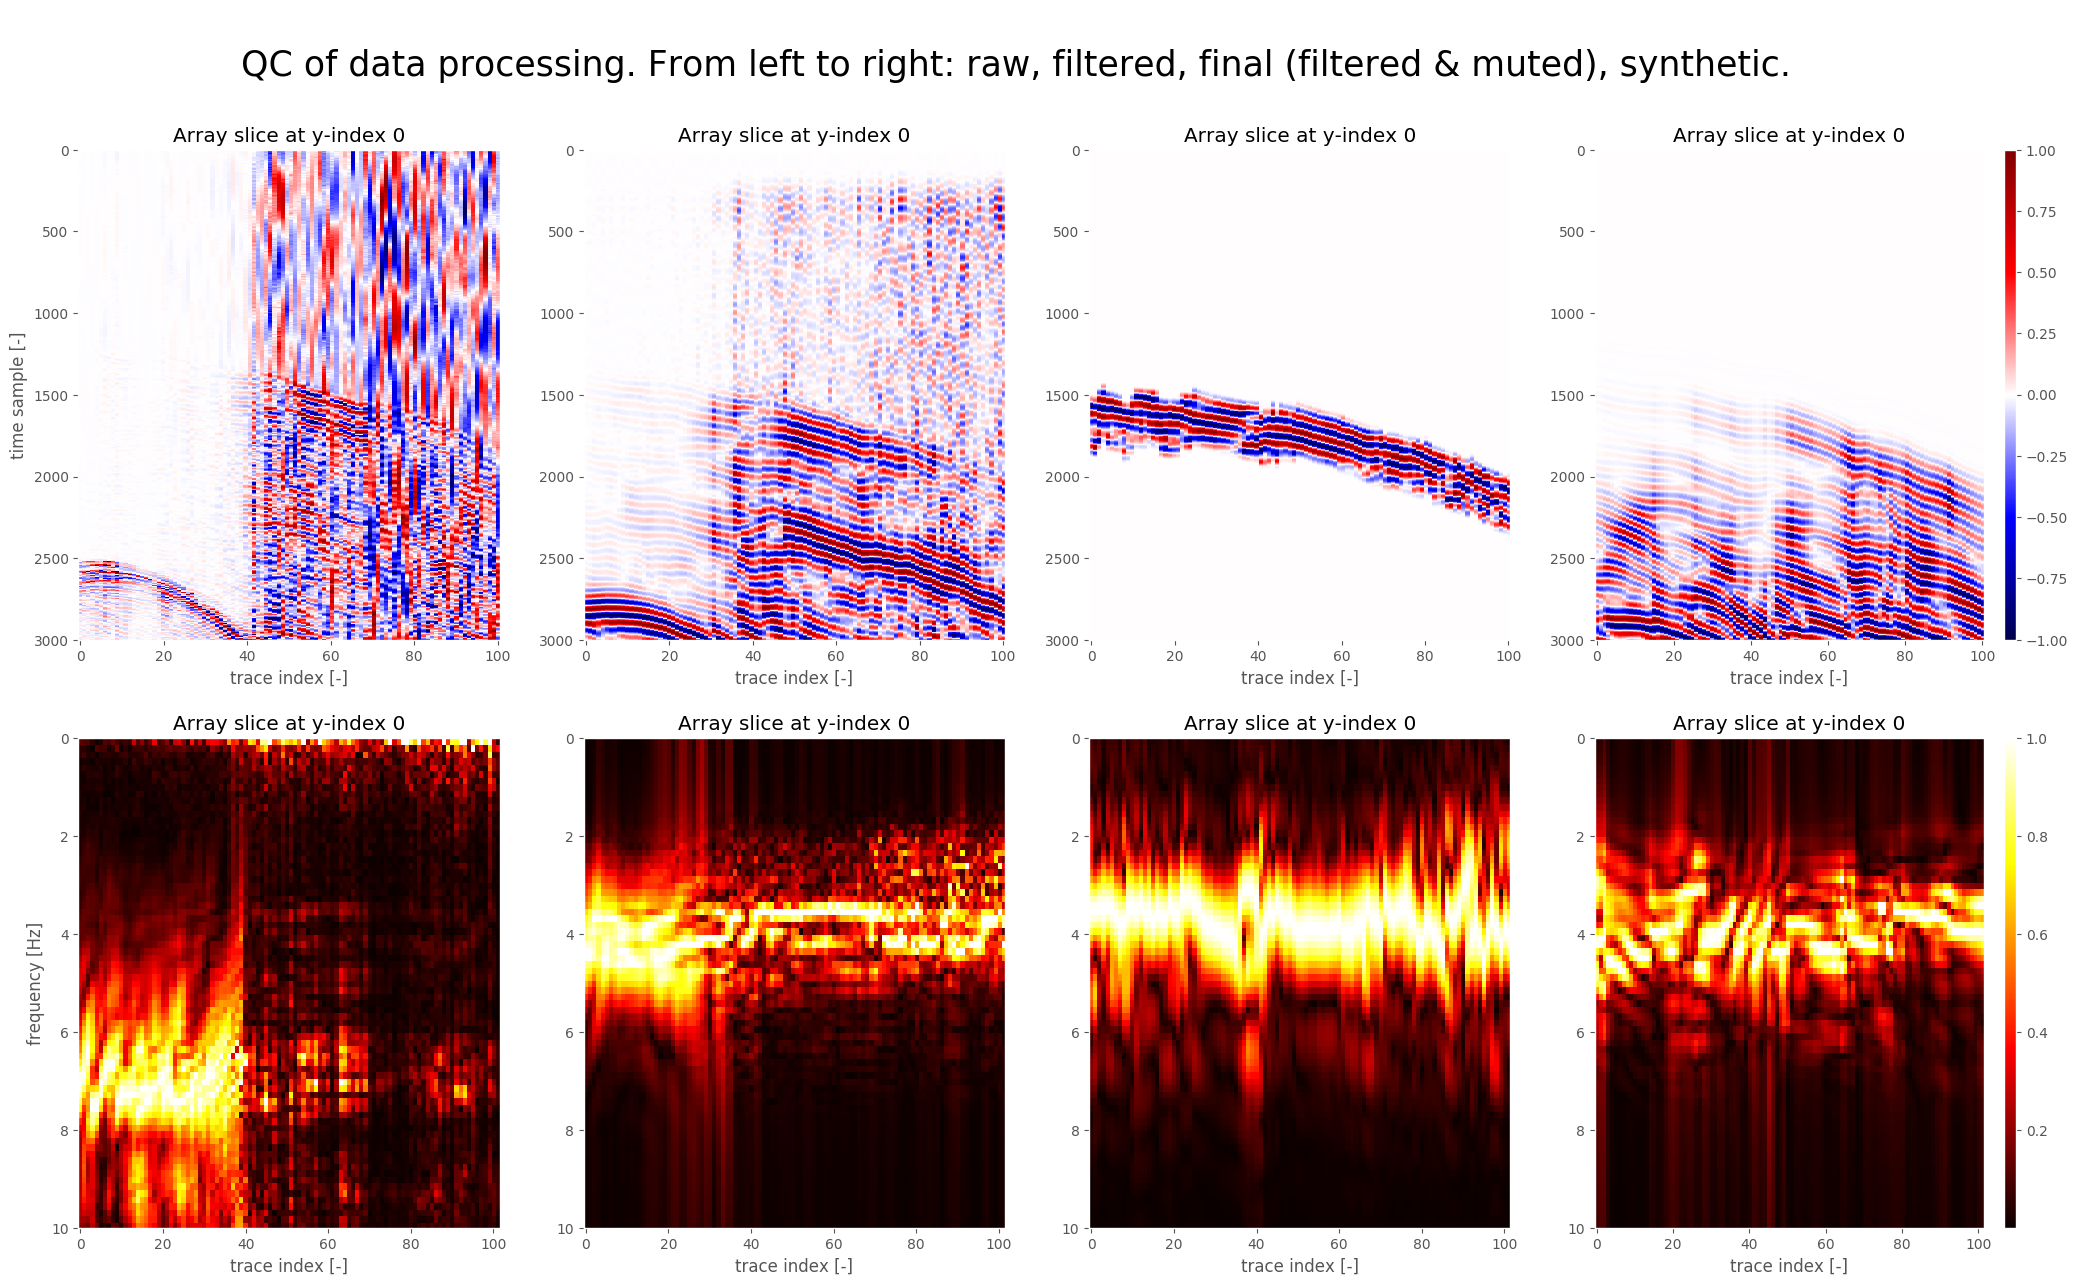

In [82]:
%%time 
qc_filt(i01, s01, sid=4139, ep=5, overwrite=1, overwrite_mmp=1)

## Run

Two nodes calculate 3000 time samples in exactly 1 hour.

In [21]:
# syn.i.rsync('my_eph') 
# syn.i.pbs.no[0].prep(q='debug')
# syn.i.pbs.no[1].prep(select=2, q='pqmrwarn') # it took exactly an hour!!!
# syn.i.rsync('my_eph') 

On the `cx1` PBS cluster, first **set environment** vars:

In [71]:
# dir=my_ephemeral/PROJECTS/ch08_Kolumbo_volcano; code=rev690; proj=method_syn01; q=pqmrwarn

and then **submit** the job(s):

In [72]:
# dir=$dir; code=$code; q=$q; projs=$(ls $dir | grep $proj);
# for proj in $projs; do echo $proj; fwi_qsub.sh $dir/$proj/ $proj $code $q; donea

## Out

### Logs

In [80]:
no = 1
# syn.o.o.no[no].cat()
# syn.o.je.no[no].cat()
# syn.o.jo.no[no].cat()

# Synthetics at Nth iteretaion

Here we will recalculate synthetic data at selected iterations using the full time duration and frequency range of the wavelet. The goal is to compare them with the unmuted field data and to  get the wavefield snapshots propagating through recovered models (the latter could have been obtained during the inversion).

In [35]:
path = '/home/kmc3817/c_projects_phd/fwi_sant_kolumbo/'
dis14 = {
 'dt': 0.0025,
 'dx': 50,
 'ns': 2000}
p14 = ProjInv('p14', path=path, cat=0, box=b01, **disc14)

For some reasone, SP needs to be re-run (sth broke in `method_s01` in the meantime)? We need to re-run it full-time-length traces because ns will be larger than in p14.

In [81]:
ds = DataSet(path='./data/dataset_obs_hy_box01', regex='*00.sgy*')

## It. 80

In [60]:
info = "Calculate synthetics through p14.out.vp.it[80]"
s80 = ProjSyn('p14it080syn', path = './', exe=exe, info=info, box=b01, **dis01, cat=0)

Forgot to set snapshots to -100, intead of -1000. But the snapshots from it160 should be enough for visualisation of wavefront healing.

### Inp

Let us duplicate the input used in the `0831_Synthetic-data_calculation` section. The only piece to update is the true model and the submission script.

In [25]:
# s80.inp.dupl(input_path='./method_s01/inp/', project_name='method_s01')
# s80.inp.tvp.dupl(p14.out.vp.it[80].fname)
s80.i.tvp.plot(coord=235, overwrite_mmp=1) # this is fine!

In [88]:
s80.i.rse.prep(fnames=['../../%s/%s' % (ds.path, i) for i in ds.names])

Content of  .//p14it080syn//inp/p14it080syn-RawSeis.txt : 
../.././data/dataset_obs_hy_box01/MGL1521_S104_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S109_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S112_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S124_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S125_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S137_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S157_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S158_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S177_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_S178_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_W105_4_x8000_25000_y-3000_15000.sgy
../.././data/dataset_obs_hy_box01/MGL1521_W110_4_x8000_25000_y-3000_15000.sgy
../..

In [90]:
%%time 
s80.i.sp.run() # have to re-run as the trace length is diff... ACTUALLY the same as method_s01


 SEGYPREP  -  Version 3.16.04                                                     
 ********

 Data preparation for 2D & 3D wavefield tomography

 Project name set to p14it080syn
 Preparing files for synthetics...

 Grid points in-line:                    341
 Grid points cross-line:                 361
 Grid points vertically:                  81
 Horiz grid spacing (metres):      50.0000000    
 Vert grid spacing (metres):       50.0000000    
 Model length (metres):            17000.0000    
 Model width (metres):             18000.0000    
 Model depth (metres):             4000.00000    

 Modelling time step (ms):         2.50000000    
 Output data delta-T (ms):         2.50000000    
 Output data length (ms):          7500.00000    
 Output data length (samples):          3000
 Time steps to model:                   3000

 Receiver-array fixed in space:          yes
 Renumber original channel numbers:       no
 Use FFID instead of SOURCE numbers:     yes
 FFID numbers are uniq

In [99]:
# s80.i.runfile.cat()# the runfile is fine, no need to re-create it

### Run

In [97]:
%%time 
s80.reinit('./')
# s80.inp.pbs.no[0].prep(q='debug') # err: Number of receivers is zero for comp shot id 15
## for some reason, only after re-running SP it worked...
# s80.inp.pbs.no[1].prep(select=4, q='pqmrwarn') # took only 10 min! :)
s80.inp.rsync('my_eph')

Content of  .//p14it080syn//inp/p14it080syn-Run1.pbs : 
#!/bin/bash

##
# FULLWAVE3D WILL BE RUN FROM proj/out/
# For more explanation, see help(fullwavepy.project.files.runfiles.PbsFile).
#
##

#PBS -N p14it080syn
#PBS -o ../out/p14it080syn-JobOut1.log
#PBS -e ../out/p14it080syn-JobErr1.log
#PBS -l walltime=01:00:00
#PBS -l select=4:mpiprocs=5:ompthreads=8:ncpus=40:mem=128gb
#PBS -l place=scatter:excl

start=`date +%s`

    # PATHS
    code_path=~/PhD/fullwave3D/rev690/bin/fullwave3D.exe
    echo 'code_path: '${code_path}

    work_dir=$PBS_O_WORKDIR/../out/ # $PBS_O_WORKDIR IS THE ONE CONTAINING THIS SCRIPT
    
    # CAVEAT  
    rm $work_dir/p14it080syn-Runfile.key   
    rm $work_dir/p14it080syn-Ghost.*


    # HARD-LINK INPUT FILES TO OUTPUT DIR WHERE THE CODE WILL RUN
    ln $PBS_O_WORKDIR/* $work_dir
    
    # CHANGE DIRECTORY TO PROJECT OUTPUT
    cd $work_dir
    
    
# DISABLE PINNING OF THE PROCESSES (MAKE ALL NODE CORES AVAILABLE TO ALL PROCESSES)
unset NCPUS
export I_MP

#### Logs

In [111]:
s80.reinit(path_eph)
no = 1
s80.o.o.no[no].cat()

Content of  /home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano/p14it080syn//out/p14it080syn-Out1.log : 
# mpiexec: No RDMA network found -- using sockets+shared memory (I_MPI_DEVICE=ssm)
# mpiexec: full path to program is /rds/general/user/kmc3817/home/PhD/fullwave3D/rev690/bin/fullwave3D.exe
# mpiexec: program arguments are: p14it080syn -1 8
# mpiexec: 20 ranks allocated via PBS select
# mpiexec: 8 OpenMP threads / rank allocated by PBS select
# mpiexec: Job has shared use of the allocated nodes. Disabling process-pinning
# mpiexec: machinefile configured as:
cx1-104-10-2.cx1.hpc.ic.ac.uk:5
cx1-104-10-4.cx1.hpc.ic.ac.uk:5
cx1-104-13-3.cx1.hpc.ic.ac.uk:5
cx1-104-1-4.cx1.hpc.ic.ac.uk:5
#
# mpiexec: Checking all nodes are ONLINE:
# mpiexec: All nodes appear ONLINE
# mpiexec: launch started at Wed 10 Nov 19:36:18 GMT 2021
# mpiexec: launching program...
# /rds/general/user/kmc3817/home/PhD/fullwave3D/rev690/bin/fullwave3D.exe p14it080syn -1 8
(cx1-104-10-2.cx1.hpc.ic.ac.uk:

### Out

In [62]:
s80.reinit(path_eph)

#### Alg.
List the output.

In [63]:
s80.o.ls()

Content of /home/kmc3817/rds_home/my_ephemeral/PROJECTS/ch08_Kolumbo_volcano/p14it080syn/out

total 6.6G
-rwx------ 1 kmc3817 root  18M Nov 10 20:09 p14it080syn-Synthetic_windowed.mmp
-rwx------ 1 kmc3817 root  18M Nov 10 20:09 p14it080syn-Synthetic_windowed.vtr
-rwx------ 1 kmc3817 root  18M Nov 10 20:09 p14it080syn-Synthetic_windowed.sgy
-rwx------ 1 kmc3817 root  381 Nov 10 19:47 p14it080syn-JobOut1.log
-rwx------ 1 kmc3817 root 7.1K Nov 10 19:47 p14it080syn-JobErr1.log
-rwx------ 1 kmc3817 root  16K Nov 10 19:47 p14it080syn-Out1.log
-rwx------ 1 kmc3817 root 282M Nov 10 19:47 p14it080syn-Synthetic.sgy
-rwx------ 1 kmc3817 root 565K Nov 10 19:47 p14it080syn-Synthetic.idx
-rwx------ 1 kmc3817 root 105M Nov 10 19:47 p14it080syn-fw-003000-csref04104-iter00001-taskid00001.vtr
-rwx------ 1 kmc3817 root 105M Nov 10 19:47 p14it080syn-fw-003000-csref04125-iter00001-taskid00001.vtr
-rwx------ 1 kmc3817 root 105M Nov 10 19:47 p14it080syn-fw-003000-csref04176-iter00001-taskid00001.vtr
-rwx----

#### Alg.
Copy the synthetics from `ephemeral` to local permanent storage. 

In [114]:
# !cp {syn.o.syn.fname} ./method_s01/out/

#### Fig.
Synthetics.

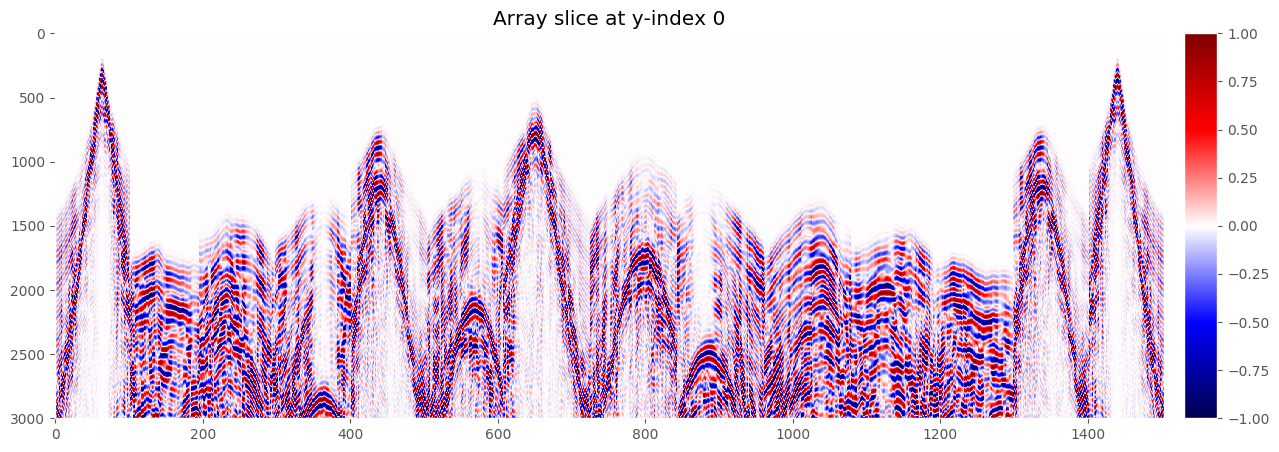

In [115]:
figure(15,5)
s80.out.syn.plot(win=dict(tracf=[4104]), norm='max')

#### Fig.
Synthetics from starting model (`method_s01`)

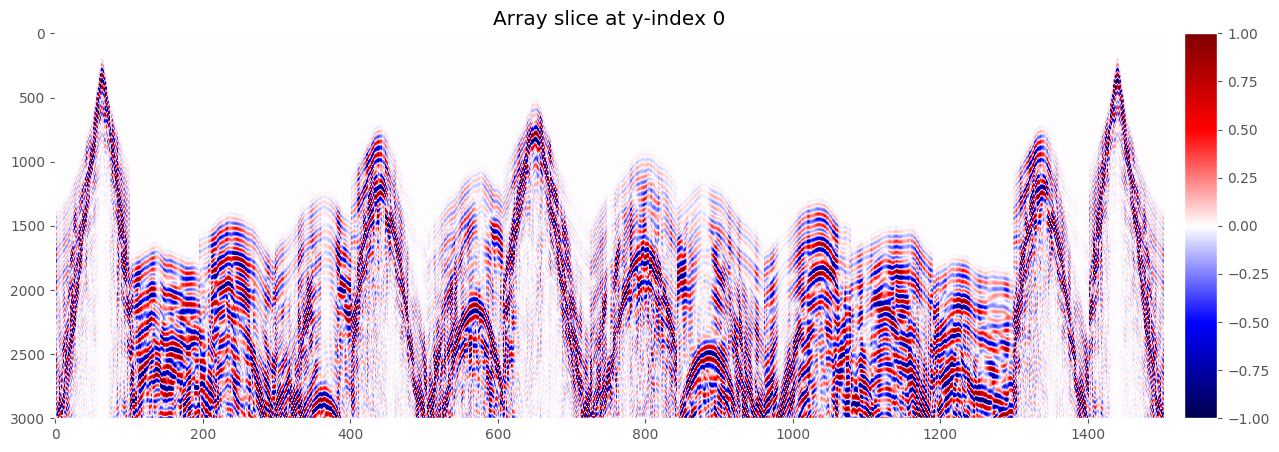

In [124]:
figure(15,5)
s01.out.syn.plot(win=dict(tracf=[4104]), norm='max')

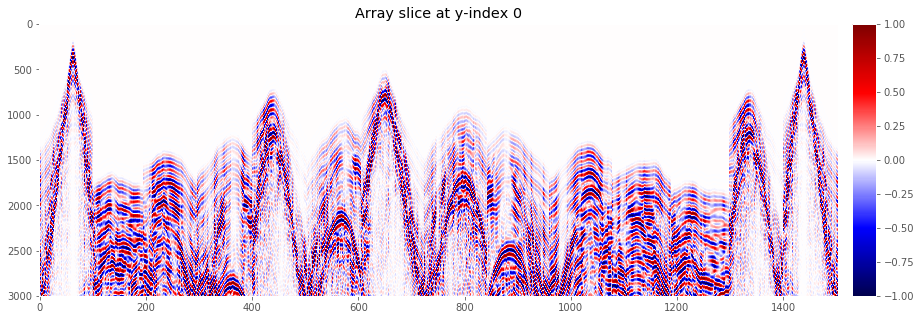

In [37]:
figure(15,5)
s01.out.syn.plot(win=dict(tracf=[4104]), norm='max')

## It. 160

In [58]:
info = "Calculate synthetics through p14.out.vp.it[160]"
env = {'SLAVES_WAVEFIELDSVTR':-100}
s160 = ProjSyn('p14it160syn', path='./', exe=exe, info=info, env=env, box=b01, **dis01, cat=0)

Let us duplicate the input used in the `0831_Synthetic-data_calculation` section. The only piece to update is the true model and the submission script.

### Inp

#### Prep

In [42]:
%%time 
s160.inp.dupl(s01)
s160.inp.tvp.dupl(p14.out.vp.it[160].fname)

CPU times: user 28 ms, sys: 60 ms, total: 88 ms
Wall time: 19.5 s


#### Check

In [44]:
# s160.inp.ls()

In [49]:
lll(20)
s160.inp.check_by_fullwave()
lll(40)

INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: 

Fullwave is checking the input...
(exe = /home/kmc3817/light_PhD/fullwave3D/rev690/bin/fullwave3D.exe)
INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: Checked input & dumped canonical runfile


INFO:fullwavepy.project.generic.io.ProjInput.check_by_fullwave: +++++++++++++++ Will only check input files and dump canonical runfile ++++++++++++++++
---=== Starting run (host: ese-kajetan) on 2021/11/11, 22:46:45 ===---
executable: fullwave3D.exe, version: unknown, release date: 2021-08-31
=== scheduler_getprojargs: Project name (command-line argument): "p14it160syn"
=== setup_probtype: Equation: "acoustic", Anisotropy: "none", Domain: "time", Kernel: "low"
+++ ReadParms: WARNING, unknown keyword in Runfile: "ibfs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "multisurf"
+++ ReadParms: WARNING, unknown keyword in Runfile: "nosprdfctrs"
+++ ReadParms: WARNING, unknown keyword in Runfile: "seaLevel"
+++ ReadParms: WARNING, unknown keyword in Runfile: "maxGhostIter"
+++ ReadParms: WARNING, unknown keyword in Runfile: "vacuum"
+++ ReadParms: WARNING, unknown keyword in Runfile: "accuracy"
+++ ReadParms: WARNING, unknown keyword in Runfile: "minGhostFS"
+++ ReadParms: WARNING, unk

INFO:fullwavepy.ioapi.generic.read_any: Set overwrite_mmp=False for faster i/o!
INFO:fullwavepy.ioapi.generic.read_any: Saving .//p14it160syn//inp/p14it160syn-TrueVp.mmp...


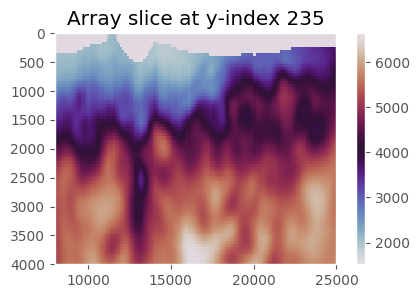

In [50]:
s160.i.tvp.plot(coord=235, overwrite_mmp=1) # this is fine!

### Run

In [59]:
%%time 
# s160.reinit(path_eph) # run once to create directories on path_eph, if not present already
s160.reinit('./')
s160.inp.pbs.no[0].prep(q='debug')
s160.inp.pbs.no[1].prep(select=4)
s160.inp.rsync('my_eph')

Content of  .//p14it160syn//inp/p14it160syn-Run0.pbs : 
#!/bin/bash

##
# FULLWAVE3D WILL BE RUN FROM proj/out/
# For more explanation, see help(fullwavepy.project.files.runfiles.PbsFile).
#
##

#PBS -N p14it160syn
#PBS -o ../out/p14it160syn-JobOut0.log
#PBS -e ../out/p14it160syn-JobErr0.log
#PBS -l walltime=00:01:00
#PBS -l select=1:mpiprocs=2:ompthreads=4:ncpus=8:mem=96gb
#PBS -l place=scatter:excl

start=`date +%s`

    # PATHS
    code_path=~/PhD/fullwave3D/rev690/bin/fullwave3D.exe
    echo 'code_path: '${code_path}

    work_dir=$PBS_O_WORKDIR/../out/ # $PBS_O_WORKDIR IS THE ONE CONTAINING THIS SCRIPT
    
    # CAVEAT  
    rm $work_dir/p14it160syn-Runfile.key   
    rm $work_dir/p14it160syn-Ghost.*


    # HARD-LINK INPUT FILES TO OUTPUT DIR WHERE THE CODE WILL RUN
    ln $PBS_O_WORKDIR/* $work_dir
    
    # CHANGE DIRECTORY TO PROJECT OUTPUT
    cd $work_dir
    
    
# DISABLE PINNING OF THE PROCESSES (MAKE ALL NODE CORES AVAILABLE TO ALL PROCESSES)
unset NCPUS
export I_MPI_

### Out

# ...